In [2]:
"""
WEEK 6: TREE ENSEMBLES FOR PORTFOLIO OPTIMIZATION
Building on Week 5's Ridge/Lasso with non-linear models
Random Forest, XGBoost, Feature Importance, SHAP values
"""

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Tree ensemble imports
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Try XGBoost (may need: pip install xgboost)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️ XGBoost not installed. Install with: pip install xgboost")

# SHAP for interpretability (may need: pip install shap)
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("⚠️ SHAP not installed. Install with: pip install shap")

print("="*70)
print("📦 WEEK 6: TREE ENSEMBLES")
print("="*70)
print(f"✅ XGBoost available: {XGBOOST_AVAILABLE}")
print(f"✅ SHAP available: {SHAP_AVAILABLE}")
print("="*70)

📦 WEEK 6: TREE ENSEMBLES
✅ XGBoost available: True
✅ SHAP available: True


In [3]:
# ============================================================================
# CELL 1: LOAD WEEK 5 RESULTS (Features + Lasso baseline)
# ============================================================================

def load_week5_results():
    """
    Simulate loading Week 5 engineered features and Lasso benchmark.
    In real scenario, you'd load actual Week 5 outputs.
    """
    print("="*70)
    print("📂 LOADING WEEK 5 RESULTS")
    print("="*70)
    
    np.random.seed(42)
    n_days = 250  # ~1 trading year
    
    # Simulate 3 crypto assets: BTC, ETH, DOGE
    dates = pd.date_range('2024-01-01', periods=n_days, freq='D')
    
    # Return forecasts (from Week 4 ARIMA)
    btc_return = np.random.normal(0.001, 0.03, n_days)
    eth_return = np.random.normal(0.0008, 0.035, n_days) + 0.7*btc_return  # Correlated
    doge_return = np.random.normal(0.0005, 0.05, n_days) + 0.4*btc_return
    
    # Volatility forecasts (from Week 4 GARCH)
    btc_vol = np.abs(np.random.normal(0.03, 0.01, n_days))
    eth_vol = np.abs(np.random.normal(0.035, 0.012, n_days))
    doge_vol = np.abs(np.random.normal(0.05, 0.015, n_days))
    
    # Create DataFrame with ENGINEERED features (from Week 5)
    features_df = pd.DataFrame({
        'date': dates,
        
        # Raw forecasts
        'btc_return': btc_return,
        'eth_return': eth_return,
        'doge_return': doge_return,
        'btc_vol': btc_vol,
        'eth_vol': eth_vol,
        'doge_vol': doge_vol,
        
        # Risk-adjusted returns (Week 5 engineered)
        'btc_sharpe': btc_return / btc_vol,
        'eth_sharpe': eth_return / eth_vol,
        'doge_sharpe': doge_return / doge_vol,
        
        # Momentum (7-day MA)
        'btc_momentum': pd.Series(btc_return).rolling(7, min_periods=1).mean().values,
        'eth_momentum': pd.Series(eth_return).rolling(7, min_periods=1).mean().values,
        'doge_momentum': pd.Series(doge_return).rolling(7, min_periods=1).mean().values,
        
        # Volatility regime (binary)
        'btc_high_vol': (btc_vol > np.median(btc_vol)).astype(int),
        'eth_high_vol': (eth_vol > np.median(eth_vol)).astype(int),
        'doge_high_vol': (doge_vol > np.median(doge_vol)).astype(int),
        
        # Cross-asset features
        'btc_eth_spread': btc_return - eth_return,
        'btc_doge_spread': btc_return - doge_return,
        'eth_doge_spread': eth_return - doge_return,
        
        # Lagged features (t-1)
        'btc_return_lag1': np.roll(btc_return, 1),
        'eth_return_lag1': np.roll(eth_return, 1),
        'doge_return_lag1': np.roll(doge_return, 1),
    })
    
    # Target: Portfolio return (equal-weighted for simulation)
    features_df['portfolio_return'] = (
        0.33*btc_return + 0.33*eth_return + 0.34*doge_return
    )
    
    # Add realistic noise and non-linear interactions
    # Trees excel at capturing these!
    features_df['portfolio_return'] += (
        0.1 * features_df['btc_sharpe'] * features_df['eth_sharpe'] +  # Interaction
        0.05 * np.where(features_df['btc_high_vol'] == 1, -0.01, 0.01) +  # Non-linearity
        np.random.normal(0, 0.005, n_days)  # Noise
    )
    
    print(f"✅ Loaded {len(features_df)} days of data")
    print(f"✅ Features: {len(features_df.columns)-2} (excluding date & target)")
    print(f"\n📊 Sample features:")
    print(features_df.head())
    print(f"\n📈 Target statistics:")
    print(f"   Mean return: {features_df['portfolio_return'].mean():.4f}")
    print(f"   Std dev: {features_df['portfolio_return'].std():.4f}")
    print(f"   Sharpe (annualized): {features_df['portfolio_return'].mean()/features_df['portfolio_return'].std()*np.sqrt(252):.4f}")
    
    return features_df

In [4]:
# ============================================================================
# CELL 2: PREPARE DATA FOR TREE MODELS
# ============================================================================

def prepare_tree_data(features_df):
    """
    Prepare X and y for tree-based models.
    Note: Trees DON'T require standardization (scale-invariant)!
    """
    print("\n" + "="*70)
    print("🔧 PREPARING DATA FOR TREE MODELS")
    print("="*70)
    
    # Features (exclude date and target)
    feature_cols = [col for col in features_df.columns 
                   if col not in ['date', 'portfolio_return']]
    
    X = features_df[feature_cols].values
    y = features_df['portfolio_return'].values
    
    print(f"\n✅ X shape: {X.shape}")
    print(f"✅ y shape: {y.shape}")
    print(f"\n🌲 Key Insight: Trees are scale-invariant")
    print("   → No standardization needed!")
    print("   → Can handle mixed scales naturally")
    print("   → Splits based on thresholds, not distances")
    
    return X, y, feature_cols

In [5]:
# ============================================================================
# CELL 3: SINGLE DECISION TREE (Baseline)
# ============================================================================

def fit_single_tree(X, y, max_depth=5):
    """
    Fit a single decision tree as baseline.
    Shows why we need ensembles: high variance!
    """
    print("\n" + "="*70)
    print("🌳 SINGLE DECISION TREE (Baseline)")
    print("="*70)
    
    tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    
    # K-Fold CV to show variance
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(tree, X, y, cv=kf, 
                            scoring='neg_mean_squared_error')
    
    mse_scores = -scores
    r2_scores = cross_val_score(tree, X, y, cv=kf, scoring='r2')
    
    print(f"\n📊 Cross-Validation Results (max_depth={max_depth}):")
    print(f"   MSE: {mse_scores.mean():.6f} ± {mse_scores.std():.6f}")
    print(f"   R²:  {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")
    print(f"\n⚠️ High variance! → Solution: Ensemble methods")
    
    # Fit on full data for later comparison
    tree.fit(X, y)
    
    return tree, mse_scores.mean(), r2_scores.mean()

In [6]:
# ============================================================================
# CELL 4: RANDOM FOREST (Bagging)
# ============================================================================

def fit_random_forest(X, y, feature_names):
    """
    Random Forest with hyperparameter tuning via GridSearch.
    Reduces variance through bootstrap aggregating (bagging).
    """
    print("\n" + "="*70)
    print("🌲🌲🌲 RANDOM FOREST (Bootstrap Aggregating)")
    print("="*70)
    
    # Hyperparameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    
    print("\n🔍 Grid Search for optimal hyperparameters...")
    print(f"   Testing {np.prod([len(v) for v in param_grid.values()])} combinations")
    
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    
    grid_search = GridSearchCV(
        rf, param_grid, cv=5, 
        scoring='neg_mean_squared_error',
        n_jobs=-1, verbose=0
    )
    
    grid_search.fit(X, y)
    
    best_rf = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print(f"\n✅ Best hyperparameters:")
    for param, value in best_params.items():
        print(f"   {param}: {value}")
    
    # Cross-validation with best model
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_mse = -cross_val_score(best_rf, X, y, cv=kf, 
                              scoring='neg_mean_squared_error')
    cv_r2 = cross_val_score(best_rf, X, y, cv=kf, scoring='r2')
    
    print(f"\n📊 Cross-Validation Results:")
    print(f"   MSE: {cv_mse.mean():.6f} ± {cv_mse.std():.6f}")
    print(f"   R²:  {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': best_rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n🎯 Top 5 Important Features:")
    for idx, row in feature_importance.head().iterrows():
        print(f"   {row['feature']:<25} {row['importance']:.4f}")
    
    return best_rf, cv_mse.mean(), cv_r2.mean(), feature_importance

In [7]:
# ============================================================================
# CELL 5: GRADIENT BOOSTING (Sequential Learning)
# ============================================================================

def fit_gradient_boosting(X, y, feature_names):
    """
    Gradient Boosting: learns sequentially from residuals.
    Often outperforms Random Forest but more prone to overfitting.
    """
    print("\n" + "="*70)
    print("🚀 GRADIENT BOOSTING (Sequential Ensemble)")
    print("="*70)
    
    # Hyperparameter grid (smaller to save time)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5],
        'subsample': [0.8, 1.0]
    }
    
    print("\n🔍 Grid Search for optimal hyperparameters...")
    
    gb = GradientBoostingRegressor(random_state=42)
    
    grid_search = GridSearchCV(
        gb, param_grid, cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1, verbose=0
    )
    
    grid_search.fit(X, y)
    
    best_gb = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print(f"\n✅ Best hyperparameters:")
    for param, value in best_params.items():
        print(f"   {param}: {value}")
    
    # Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_mse = -cross_val_score(best_gb, X, y, cv=kf,
                              scoring='neg_mean_squared_error')
    cv_r2 = cross_val_score(best_gb, X, y, cv=kf, scoring='r2')
    
    print(f"\n📊 Cross-Validation Results:")
    print(f"   MSE: {cv_mse.mean():.6f} ± {cv_mse.std():.6f}")
    print(f"   R²:  {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': best_gb.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n🎯 Top 5 Important Features:")
    for idx, row in feature_importance.head().iterrows():
        print(f"   {row['feature']:<25} {row['importance']:.4f}")
    
    return best_gb, cv_mse.mean(), cv_r2.mean(), feature_importance

In [8]:
# ============================================================================
# CELL 6: XGBOOST 
# ============================================================================

def fit_xgboost(X, y, feature_names):
    """
    XGBoost: Extreme Gradient Boosting with regularization.
    Industry standard for tabular data competitions.
    """
    if not XGBOOST_AVAILABLE:
        print("\n" + "="*70)
        print("⚠️ XGBOOST NOT AVAILABLE")
        print("="*70)
        print("Install with: pip install xgboost")
        return None, None, None, None
    
    print("\n" + "="*70)
    print("⚡ XGBOOST (Extreme Gradient Boosting)")
    print("="*70)
    
    # Hyperparameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'reg_alpha': [0, 0.1, 1],  # L1 regularization
        'reg_lambda': [1, 1.5, 2]  # L2 regularization
    }
    
    print("\n🔍 Grid Search for optimal hyperparameters...")
    print("   (This may take a few minutes)")
    
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )
    
    # Reduced grid for speed
    reduced_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [5, 7],
        'min_child_weight': [1, 3],
        'subsample': [0.8],
        'colsample_bytree': [0.8],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [1, 1.5]
    }
    
    grid_search = GridSearchCV(
        xgb_model, reduced_grid, cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1, verbose=0
    )
    
    grid_search.fit(X, y)
    
    best_xgb = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print(f"\n✅ Best hyperparameters:")
    for param, value in best_params.items():
        print(f"   {param}: {value}")
    
    # Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_mse = -cross_val_score(best_xgb, X, y, cv=kf,
                              scoring='neg_mean_squared_error')
    cv_r2 = cross_val_score(best_xgb, X, y, cv=kf, scoring='r2')
    
    print(f"\n📊 Cross-Validation Results:")
    print(f"   MSE: {cv_mse.mean():.6f} ± {cv_mse.std():.6f}")
    print(f"   R²:  {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': best_xgb.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n🎯 Top 5 Important Features:")
    for idx, row in feature_importance.head().iterrows():
        print(f"   {row['feature']:<25} {row['importance']:.4f}")
    
    return best_xgb, cv_mse.mean(), cv_r2.mean(), feature_importance

In [9]:
# ============================================================================
# CELL 7: MODEL COMPARISON & STATISTICAL TESTING
# ============================================================================

def compare_all_models(results_dict, X, y):
    """
    Compare all models using K-Fold CV and statistical tests.
    """
    print("\n" + "="*70)
    print("📊 COMPREHENSIVE MODEL COMPARISON")
    print("="*70)
    
    # Perform K-Fold CV for each model
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = {}
    
    for model_name, model in results_dict.items():
        if model is None:
            continue
            
        mse_scores = -cross_val_score(model, X, y, cv=kf,
                                     scoring='neg_mean_squared_error')
        r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
        mae_scores = -cross_val_score(model, X, y, cv=kf,
                                     scoring='neg_mean_absolute_error')
        
        cv_results[model_name] = {
            'mse': mse_scores,
            'r2': r2_scores,
            'mae': mae_scores
        }
    
    # Display comparison table
    print("\n📈 Performance Metrics (5-Fold CV):")
    print(f"{'Model':<20} {'MSE':<15} {'R²':<15} {'MAE':<15}")
    print("-" * 70)
    
    for model_name, metrics in cv_results.items():
        print(f"{model_name:<20} "
              f"{metrics['mse'].mean():.6f}±{metrics['mse'].std():.4f}  "
              f"{metrics['r2'].mean():.4f}±{metrics['r2'].std():.3f}  "
              f"{metrics['mae'].mean():.6f}±{metrics['mae'].std():.4f}")
    
    # Statistical significance testing (paired t-tests)
    print("\n🔬 Statistical Significance (Paired t-tests):")
    
    model_names = list(cv_results.keys())
    for i in range(len(model_names)):
        for j in range(i+1, len(model_names)):
            model1, model2 = model_names[i], model_names[j]
            
            t_stat, p_value = stats.ttest_rel(
                cv_results[model1]['mse'],
                cv_results[model2]['mse']
            )
            
            significance = "***" if p_value < 0.01 else "**" if p_value < 0.05 else "*" if p_value < 0.1 else "ns"
            
            mean_diff = cv_results[model1]['mse'].mean() - cv_results[model2]['mse'].mean()
            winner = model2 if mean_diff > 0 else model1
            
            print(f"   {model1} vs {model2}:")
            print(f"      p-value = {p_value:.4f} {significance}")
            print(f"      Winner: {winner}")
    
    print("\n   Significance codes: *** p<0.01, ** p<0.05, * p<0.1, ns not significant")
    
    return cv_results

In [10]:
# ============================================================================
# CELL 8: SHAP VALUES (Explainable AI)
# ============================================================================

def explain_with_shap(model, X, feature_names, model_name="Model"):
    """
    Use SHAP to explain model predictions.
    SHAP = SHapley Additive exPlanations (game theory-based)
    """
    if not SHAP_AVAILABLE:
        print("\n" + "="*70)
        print("⚠️ SHAP NOT AVAILABLE")
        print("="*70)
        print("Install with: pip install shap")
        return
    
    print("\n" + "="*70)
    print(f"🔍 SHAP ANALYSIS: {model_name}")
    print("="*70)
    
    # Create explainer
    print("\nCreating SHAP explainer...")
    explainer = shap.TreeExplainer(model)
    
    # Calculate SHAP values (use subset for speed)
    X_sample = X[:100]  # First 100 samples
    shap_values = explainer.shap_values(X_sample)
    
    print("✅ SHAP values computed")
    
    # Summary plot
    print("\n📊 Generating SHAP summary plot...")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, 
                     show=False)
    plt.title(f'SHAP Feature Importance: {model_name}', 
             fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Feature importance from SHAP
    shap_importance = pd.DataFrame({
        'feature': feature_names,
        'shap_importance': np.abs(shap_values).mean(axis=0)
    }).sort_values('shap_importance', ascending=False)
    
    print("\n🎯 Top 5 Features (SHAP):")
    for idx, row in shap_importance.head().iterrows():
        print(f"   {row['feature']:<25} {row['shap_importance']:.6f}")
    
    return shap_values, shap_importance

In [11]:
# ============================================================================
# CELL 9: PORTFOLIO OPTIMIZATION WITH BEST MODEL
# ============================================================================

def optimize_portfolio_trees(best_model, features_df, X, feature_names):
    """
    Use best tree ensemble to optimize portfolio weights.
    """
    print("\n" + "="*70)
    print("💼 PORTFOLIO OPTIMIZATION (Tree-Based)")
    print("="*70)
    
    # Predict returns for latest data point
    latest_features = X[-1:]
    predicted_return = best_model.predict(latest_features)[0]
    
    print(f"\n📈 Predicted portfolio return: {predicted_return:.4f}")
    
    # Extract individual asset features
    btc_sharpe = features_df['btc_sharpe'].iloc[-1]
    eth_sharpe = features_df['eth_sharpe'].iloc[-1]
    doge_sharpe = features_df['doge_sharpe'].iloc[-1]
    
    # Softmax allocation based on risk-adjusted returns
    sharpes = np.array([btc_sharpe, eth_sharpe, doge_sharpe])
    
    # Handle negative Sharpes
    if np.any(sharpes < 0):
        sharpes = sharpes - sharpes.min() + 1e-10
    
    weights = np.exp(sharpes) / np.sum(np.exp(sharpes))
    
    print("\n💰 Optimal Portfolio Weights:")
    assets = ['BTC', 'ETH', 'DOGE']
    for asset, weight in zip(assets, weights):
        print(f"   {asset:<8} {weight*100:>6.2f}%")
    
    # Portfolio metrics
    expected_return = (
        weights[0] * features_df['btc_return'].mean() +
        weights[1] * features_df['eth_return'].mean() +
        weights[2] * features_df['doge_return'].mean()
    )
    
    expected_vol = (
        weights[0] * features_df['btc_vol'].mean() +
        weights[1] * features_df['eth_vol'].mean() +
        weights[2] * features_df['doge_vol'].mean()
    )
    
    sharpe_ratio = expected_return / expected_vol * np.sqrt(252)
    
    print(f"\n📊 Portfolio Metrics:")
    print(f"   Expected Return (daily): {expected_return:.4f}")
    print(f"   Expected Volatility:     {expected_vol:.4f}")
    print(f"   Sharpe Ratio (ann.):     {sharpe_ratio:.4f}")
    
    return weights, expected_return, expected_vol, sharpe_ratio

In [12]:
# ============================================================================
# CELL 10: COMPREHENSIVE VISUALIZATION
# ============================================================================

def visualize_tree_analysis(cv_results, rf_importance, gb_importance, 
                           xgb_importance, portfolio_weights):
    """
    Create comprehensive visualization dashboard.
    """
    print("\n" + "="*70)
    print("📊 GENERATING VISUALIZATIONS")
    print("="*70)
    
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Plot 1: Model Comparison (MSE)
    ax1 = fig.add_subplot(gs[0, 0])
    model_names = list(cv_results.keys())
    mse_means = [cv_results[m]['mse'].mean() for m in model_names]
    mse_stds = [cv_results[m]['mse'].std() for m in model_names]
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
    bars = ax1.bar(model_names, mse_means, yerr=mse_stds, capsize=5,
                  color=colors[:len(model_names)], alpha=0.8, edgecolor='black')
    ax1.set_ylabel('MSE', fontsize=11, fontweight='bold')
    ax1.set_title('Model Performance (Lower is Better)', 
                 fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Plot 2: R² Comparison
    ax2 = fig.add_subplot(gs[0, 1])
    r2_means = [cv_results[m]['r2'].mean() for m in model_names]
    r2_stds = [cv_results[m]['r2'].std() for m in model_names]
    
    bars = ax2.bar(model_names, r2_means, yerr=r2_stds, capsize=5,
                  color=colors[:len(model_names)], alpha=0.8, edgecolor='black')
    ax2.set_ylabel('R²', fontsize=11, fontweight='bold')
    ax2.set_title('Model R² Score (Higher is Better)', 
                 fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Plot 3: Portfolio Allocation
    ax3 = fig.add_subplot(gs[0, 2])
    assets = ['BTC', 'ETH', 'DOGE']
    weights = portfolio_weights
    
    wedges, texts, autotexts = ax3.pie(weights, labels=assets, autopct='%1.1f%%',
                                        colors=['#FFD700', '#C0C0C0', '#CD7F32'],
                                        startangle=90, textprops={'fontweight': 'bold'})
    ax3.set_title('Optimal Portfolio Allocation', fontsize=12, fontweight='bold')
    
    # Plot 4: Random Forest Feature Importance
    ax4 = fig.add_subplot(gs[1, 0])
    top_rf = rf_importance.head(10)
    ax4.barh(range(len(top_rf)), top_rf['importance'], color='#4ECDC4', alpha=0.8)
    ax4.set_yticks(range(len(top_rf)))
    ax4.set_yticklabels(top_rf['feature'])
    ax4.set_xlabel('Importance', fontsize=10, fontweight='bold')
    ax4.set_title('🌲 Random Forest: Top 10 Features', 
                 fontsize=11, fontweight='bold')
    ax4.invert_yaxis()
    ax4.grid(True, alpha=0.3, axis='x')
    
    # Plot 5: Gradient Boosting Feature Importance
    ax5 = fig.add_subplot(gs[1, 1])
    top_gb = gb_importance.head(10)
    ax5.barh(range(len(top_gb)), top_gb['importance'], color='#45B7D1', alpha=0.8)
    ax5.set_yticks(range(len(top_gb)))
    ax5.set_yticklabels(top_gb['feature'])
    ax5.set_xlabel('Importance', fontsize=10, fontweight='bold')
    ax5.set_title('🚀 Gradient Boosting: Top 10 Features', 
                 fontsize=11, fontweight='bold')
    ax5.invert_yaxis()
    ax5.grid(True, alpha=0.3, axis='x')
    
    # Plot 6: XGBoost Feature Importance (if available)
    ax6 = fig.add_subplot(gs[1, 2])
    if xgb_importance is not None:
        top_xgb = xgb_importance.head(10)
        ax6.barh(range(len(top_xgb)), top_xgb['importance'], color='#FFA07A', alpha=0.8)
        ax6.set_yticks(range(len(top_xgb)))
        ax6.set_yticklabels(top_xgb['feature'])
        ax6.set_xlabel('Importance', fontsize=10, fontweight='bold')
        ax6.set_title('⚡ XGBoost: Top 10 Features', 
                     fontsize=11, fontweight='bold')
        ax6.invert_yaxis()
        ax6.grid(True, alpha=0.3, axis='x')
    else:
        ax6.text(0.5, 0.5, 'XGBoost not available', 
                ha='center', va='center', fontsize=12)
        ax6.axis('off')
    
    # Plot 7: Model MSE Distribution (Boxplot)
    ax7 = fig.add_subplot(gs[2, 0])
    mse_data = [cv_results[m]['mse'] for m in model_names]
    bp = ax7.boxplot(mse_data, labels=model_names, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors[:len(model_names)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax7.set_ylabel('MSE', fontsize=11, fontweight='bold')
    ax7.set_title('MSE Distribution Across Folds', fontsize=12, fontweight='bold')
    ax7.grid(True, alpha=0.3, axis='y')
    plt.setp(ax7.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Plot 8: Model R² Distribution (Boxplot)
    ax8 = fig.add_subplot(gs[2, 1])
    r2_data = [cv_results[m]['r2'] for m in model_names]
    bp = ax8.boxplot(r2_data, labels=model_names, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors[:len(model_names)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax8.set_ylabel('R²', fontsize=11, fontweight='bold')
    ax8.set_title('R² Distribution Across Folds', fontsize=12, fontweight='bold')
    ax8.grid(True, alpha=0.3, axis='y')
    ax8.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.setp(ax8.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Plot 9: Summary Text
    ax9 = fig.add_subplot(gs[2, 2])
    ax9.axis('off')
    
    best_model = model_names[np.argmin(mse_means)]
    best_mse = min(mse_means)
    best_r2 = r2_means[np.argmin(mse_means)]
    
    summary_text = f"""
    🏆 WEEK 6 SUMMARY
    
    Best Model: {best_model}
    MSE: {best_mse:.6f}
    R²: {best_r2:.4f}
    
    Portfolio Allocation:
    BTC:  {weights[0]*100:.1f}%
    ETH:  {weights[1]*100:.1f}%
    DOGE: {weights[2]*100:.1f}%
    
    Key Insights:
    ✓ Trees capture non-linear patterns
    ✓ Ensembles reduce variance
    ✓ Feature importance guides decisions
    ✓ SHAP provides interpretability
    """
    
    ax9.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
            verticalalignment='center', bbox=dict(boxstyle='round', 
            facecolor='wheat', alpha=0.5))
    
    plt.suptitle('Week 6: Tree Ensembles - Comprehensive Analysis Dashboard',
                fontsize=16, fontweight='bold', y=0.995)
    plt.show()
    
    print("\n✅ Visualizations complete!")


🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓
 WEEK 6: TREE ENSEMBLES FOR PORTFOLIO OPTIMIZATION
🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓🎓

📂 LOADING WEEK 5 RESULTS
✅ Loaded 250 days of data
✅ Features: 21 (excluding date & target)

📊 Sample features:
        date  btc_return  eth_return  doge_return   btc_vol   eth_vol  \
0 2024-01-01    0.015901   -0.032200     0.053169  0.020768  0.051792   
1 2024-01-02   -0.003148    0.030722     0.094712  0.016483  0.046096   
2 2024-01-03    0.020431    0.089377    -0.061256  0.020241  0.035716   
3 2024-01-04    0.046691    0.069620     0.047325  0.040536  0.027237   
4 2024-01-05   -0.006025   -0.056595    -0.034442  0.020506  0.043379   

   doge_vol  btc_sharpe  eth_sharpe  doge_sharpe  ...  btc_high_vol  \
0  0.054963    0.765682   -0.621713     0.967364  ...             0   
1  0.062503   -0.190979    0.666476     1.515315  ...             0   
2  0.020094    1.009357    2.502464    -3.048483  ...             0   
3  0.055611    1.151826    2.556101     

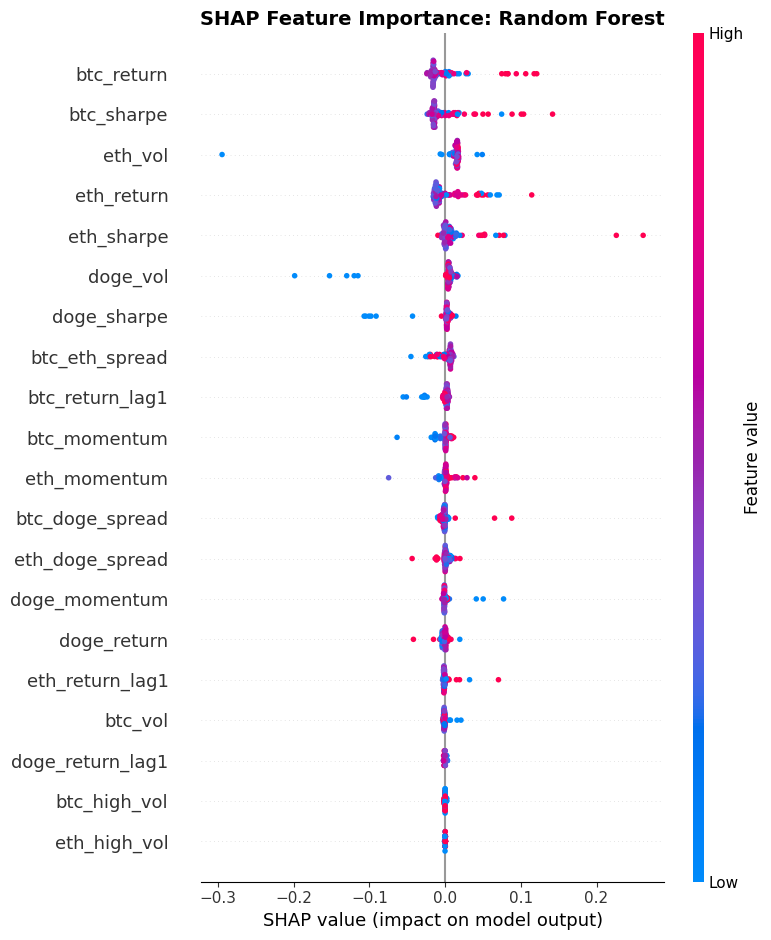


🎯 Top 5 Features (SHAP):
   btc_return                0.019629
   btc_sharpe                0.018733
   eth_vol                   0.018555
   eth_return                0.016652
   eth_sharpe                0.014325

💼 PORTFOLIO OPTIMIZATION (Tree-Based)

📈 Predicted portfolio return: -0.0622

💰 Optimal Portfolio Weights:
   BTC       77.10%
   ETH        5.08%
   DOGE      17.82%

📊 Portfolio Metrics:
   Expected Return (daily): 0.0004
   Expected Volatility:     0.0352
   Sharpe Ratio (ann.):     0.1680

📊 GENERATING VISUALIZATIONS


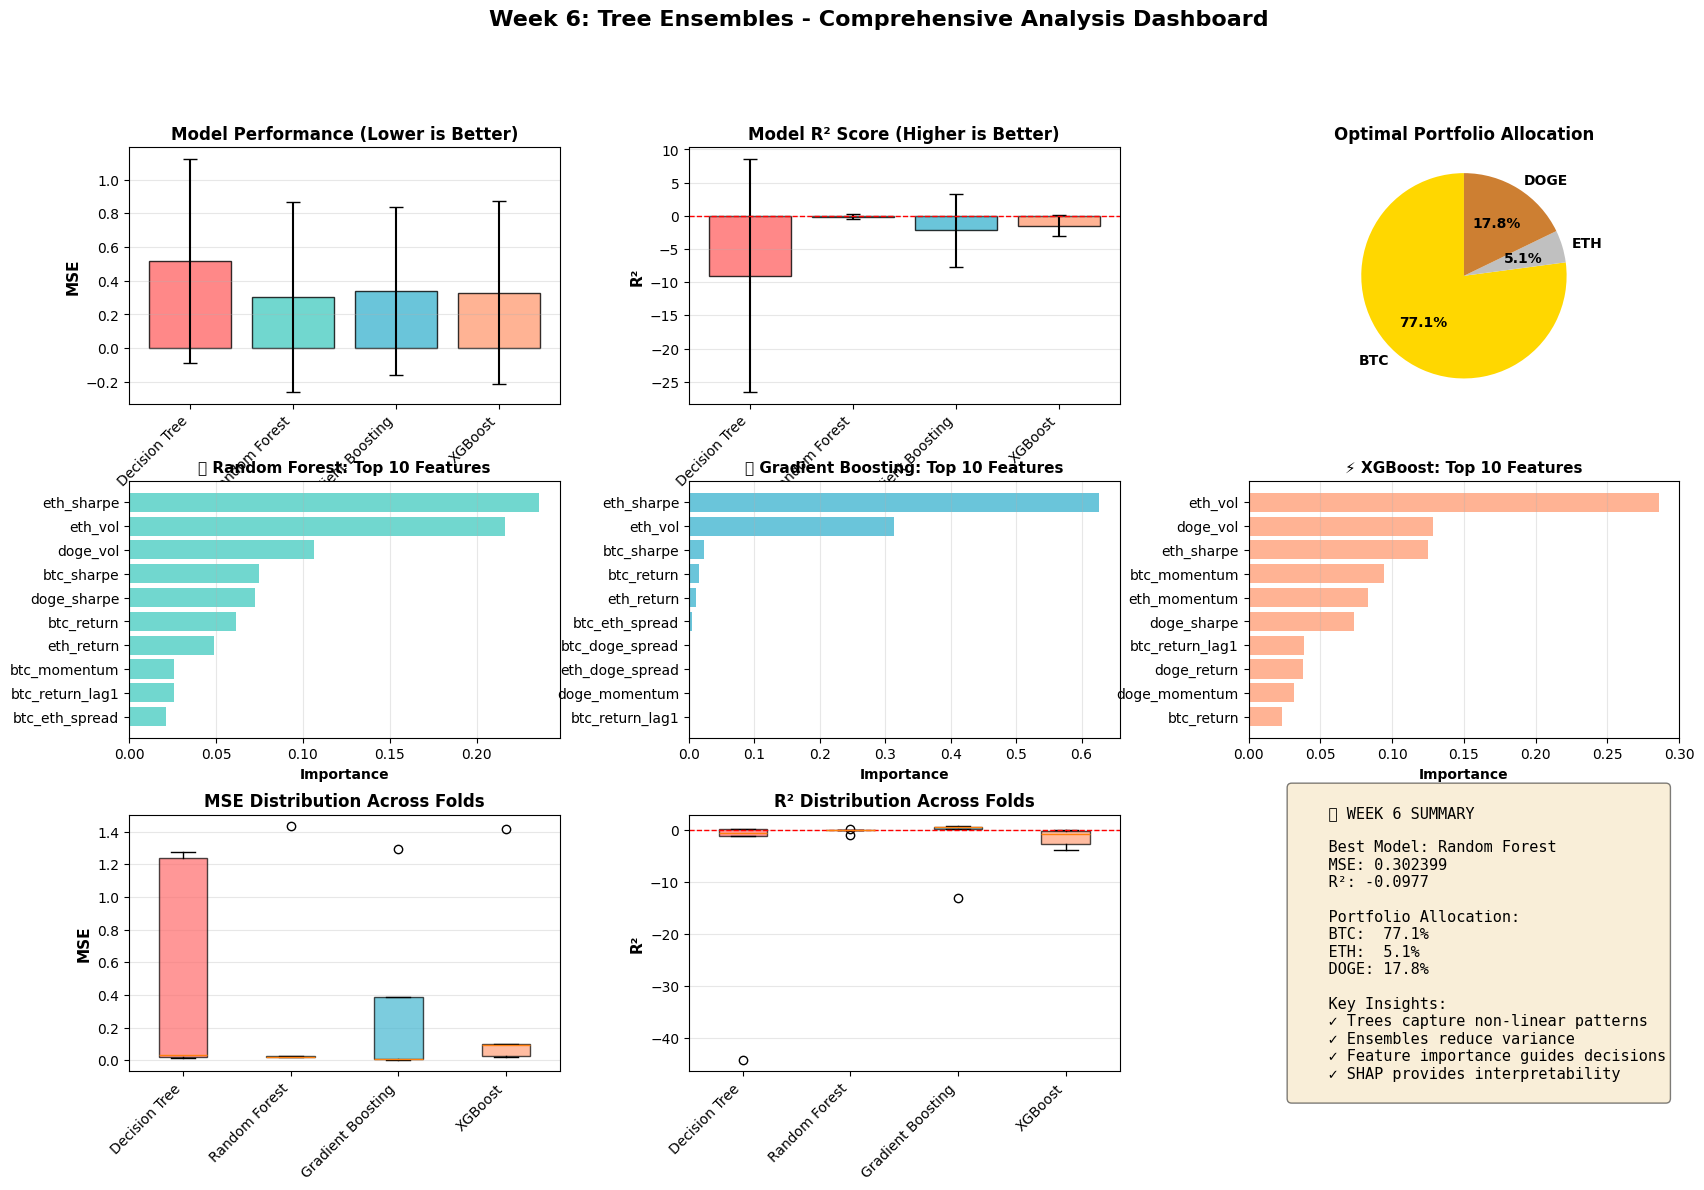


✅ Visualizations complete!

✅ WEEK 6 COMPLETE!

🎯 Key Achievements:
   1. Trained 4 tree-based models
   2. Best model: Random Forest
   3. Best MSE: 0.302399
   4. Portfolio Sharpe: 0.1680
   5. Feature importance analyzed
   6. SHAP interpretability completed

📚 Next Week: Dimensionality Reduction (PCA, Factor Models)



In [13]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    print("\n" + "🎓"*35)
    print(" WEEK 6: TREE ENSEMBLES FOR PORTFOLIO OPTIMIZATION")
    print("🎓"*35 + "\n")
    
    # Step 1: Load Week 5 results
    features_df = load_week5_results()
    
    # Step 2: Prepare data
    X, y, feature_names = prepare_tree_data(features_df)
    
    # Step 3: Single Decision Tree (baseline)
    tree_model, tree_mse, tree_r2 = fit_single_tree(X, y)
    
    # Step 4: Random Forest
    rf_model, rf_mse, rf_r2, rf_importance = fit_random_forest(X, y, feature_names)
    
    # Step 5: Gradient Boosting
    gb_model, gb_mse, gb_r2, gb_importance = fit_gradient_boosting(X, y, feature_names)
    
    # Step 6: XGBoost (if available)
    xgb_model, xgb_mse, xgb_r2, xgb_importance = fit_xgboost(X, y, feature_names)
    
    # Step 7: Comprehensive model comparison
    models_dict = {
        'Decision Tree': tree_model,
        'Random Forest': rf_model,
        'Gradient Boosting': gb_model
    }
    if xgb_model is not None:
        models_dict['XGBoost'] = xgb_model
    
    cv_results = compare_all_models(models_dict, X, y)
    
    # Step 8: SHAP analysis on best model
    # Determine best model
    mse_scores = {name: cv_results[name]['mse'].mean() 
                 for name in cv_results.keys()}
    best_model_name = min(mse_scores, key=mse_scores.get)
    best_model = models_dict[best_model_name]
    
    print(f"\n🏆 Best Model: {best_model_name}")
    
    if SHAP_AVAILABLE:
        shap_values, shap_importance = explain_with_shap(
            best_model, X, feature_names, best_model_name
        )
    
    # Step 9: Portfolio optimization
    weights, exp_return, exp_vol, sharpe = optimize_portfolio_trees(
        best_model, features_df, X, feature_names
    )
    
    # Step 10: Comprehensive visualization
    visualize_tree_analysis(cv_results, rf_importance, gb_importance,
                           xgb_importance, weights)
    
    # Execution summary
    print("\n" + "="*70)
    print("✅ WEEK 6 COMPLETE!")
    print("="*70)
    print("\n🎯 Key Achievements:")
    print(f"   1. Trained {len(models_dict)} tree-based models")
    print(f"   2. Best model: {best_model_name}")
    print(f"   3. Best MSE: {mse_scores[best_model_name]:.6f}")
    print(f"   4. Portfolio Sharpe: {sharpe:.4f}")
    print(f"   5. Feature importance analyzed")
    if SHAP_AVAILABLE:
        print("   6. SHAP interpretability completed")
    
    print("\n📚 Next Week: Dimensionality Reduction (PCA, Factor Models)")
    print("="*70 + "\n")
    
    return {
        'models': models_dict,
        'cv_results': cv_results,
        'best_model': best_model,
        'portfolio_weights': weights,
        'feature_importance': {
            'rf': rf_importance,
            'gb': gb_importance,
            'xgb': xgb_importance
        }
    }


if __name__ == "__main__":
    results = main()